In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
import itertools
from matplotlib.patches import FancyArrowPatch
from matplotlib.collections import PatchCollection
import plotly.graph_objects as go
from collections import Counter

In [3]:
element_properties = {
    'C': {'weight': 12.01, 'size': 1.70, 'charge': 0},
    'O': {'weight': 16.00, 'size': 1.52, 'charge': -2},
    'N': {'weight': 14.01, 'size': 1.55, 'charge': 1},
    'H': {'weight': 1.01, 'size': 1.20, 'charge': 1}
}

In [4]:
def parse_pdb(file_name):
    atoms = []
    bonds = []
    atom_serial_to_index = {}
    
    with open(file_name, 'r') as file:
        for line in file:
            if line.startswith('HETATM'):
                atom_serial = int(line[6:11].strip())
                atom_name = line[12:16].strip()
                residue_name = line[17:20].strip()
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                element = line[76:78].strip()
                
                properties = element_properties.get(element, {'weight': 0.0, 'size': 0.0, 'charge': 0.0})
                
                atom = {
                    'serial': atom_serial,
                    'name': atom_name,
                    'residue_name': residue_name,
                    'element': element,
                    'x': x,
                    'y': y,
                    'z': z,
                    'weight': properties['weight'],
                    'size': properties['size'],
                    'charge': properties['charge']
                }
                
                atoms.append(atom)
                atom_serial_to_index[atom_serial] = len(atoms) - 1

            if line.startswith('CONECT'):
                parts = line.split()
                source = int(parts[1])
                targets = [int(target) for target in parts[2:]]
                for target in targets:
                    bonds.append((source, target))

    return atoms, bonds

In [5]:
def remove_hydrogen_nodes(G):
    nodes_to_remove = [node for node, data in G.nodes(data=True) if data.get('element') == 'H']
    G.remove_nodes_from(nodes_to_remove)

In [6]:
def createG(file_name):
    atoms, bonds = parse_pdb(file_name)
    G = nx.MultiGraph()
    
    for atom in atoms:
        G.add_node(atom['serial'], **atom)
    
    for bond in bonds:
        G.add_edge(bond[0], bond[1])
    return G

In [7]:
def G_attr(G):
    print("Vertices and their attributes:")
    for node, data in G.nodes(data=True):
        print(f"Node {node}: {data}")
    
    print("\nEdges and their attributes:")
    for u, v in G.edges():
        print(f"Edge ({u}, {v})")

In [8]:
def draw2d(G):
    
    pos = nx.spring_layout(G)
    node_labels = {node: G.nodes[node]['name'] for node in G.nodes()}
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

    # Draw edges, including parallel edges using FancyArrowPatch
    ax = plt.gca()
    seen = {}
    
    for u, v, key, data in G.edges(data=True, keys=True):
        if (u, v) not in seen:
            seen[(u, v)] = 0
        else:
            seen[(u, v)] += 1
        rad = 0.1 * seen[(u, v)]
        
        arrow = FancyArrowPatch(
            posA=pos[u], posB=pos[v],
            connectionstyle=f"arc3,rad={rad}",
            arrowstyle="-",  # Line without arrowheads
            mutation_scale=10.0,
            color="black"
        )
        ax.add_patch(arrow)
    
    plt.show()

In [9]:
def G_det(G):
    center_nodes = nx.center(G)
    center_names = [G.nodes[node]['name'] for node in center_nodes]
    print("Center of the graph:", center_names)
    
    radius = nx.radius(G)
    print("Radius of the graph:", radius)
    
    diameter = nx.diameter(G)
    print("Diameter of the graph:", diameter)

    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    print("Degree sequence of the graph:", degree_sequence)

    num_nodes = G.number_of_nodes()
    print("Number of nodes:", num_nodes)

    num_edges = G.number_of_edges()
    print("Number of edges:", num_edges)

In [10]:
def detect_communities_girvan_newman(G):
    comp = girvan_newman(G)
    limited = itertools.takewhile(lambda c: len(c) <= 5, comp)
    communities = list(limited)[-1]
    return communities

In [11]:
def draw2d_comm(G):
        # Ensure the graph is a MultiGraph to allow for parallel edges
    if not isinstance(G, nx.MultiGraph):
        G = nx.MultiGraph(G)

    communities = detect_communities_girvan_newman(G)
    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = i
    pos = nx.spring_layout(G)
    node_labels = {node: G.nodes[node]['name'] for node in G.nodes()}
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], cmap=plt.cm.viridis, node_size=500)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='white')

    # Draw edges, including parallel edges using FancyArrowPatch
    ax = plt.gca()
    seen = {}
    
    for u, v, key, data in G.edges(data=True, keys=True):
        if (u, v) not in seen:
            seen[(u, v)] = 0
        else:
            seen[(u, v)] += 1
        rad = 0.1 * seen[(u, v)]
        
        arrow = FancyArrowPatch(
            posA=pos[u], posB=pos[v],
            connectionstyle=f"arc3,rad={rad}",
            arrowstyle="-",  # Line without arrowheads
            mutation_scale=10.0,
            color="black"
        )
        ax.add_patch(arrow)

    plt.show()



Graph created for Peramivir.pdb:
Center of the graph: ['C1']
Radius of the graph: 5
Diameter of the graph: 10
Degree sequence of the graph: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of nodes: 51
Number of edges: 54
Communities: ({1, 41, 42, 43, 12, 13, 14, 46, 16, 15, 44, 45, 51, 21, 22, 23, 24}, {2, 3, 4, 5, 6, 25, 26, 27, 28, 29}, {36, 37, 38, 7, 40, 39, 10, 11, 30}, {32, 33, 34, 35, 8, 9, 31}, {47, 48, 17, 18, 19, 20, 49, 50})


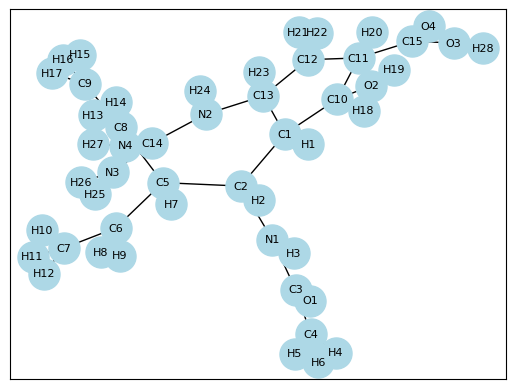

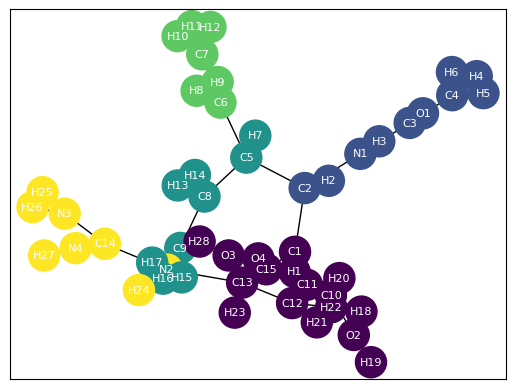


Graph created for Zanamivir.pdb:
Center of the graph: ['C1', 'C6']
Radius of the graph: 6
Diameter of the graph: 11
Degree sequence of the graph: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of nodes: 43
Number of edges: 47
Communities: ({1, 2, 3, 4, 5, 10, 24, 25, 26, 31}, {6, 7, 8, 9, 27, 28, 29, 30}, {32, 33, 34, 35, 11, 12, 13, 14}, {16, 17, 36, 15}, {37, 38, 39, 40, 41, 42, 43, 18, 19, 20, 21, 22, 23})


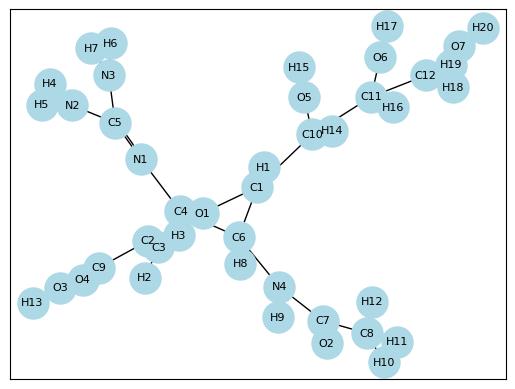

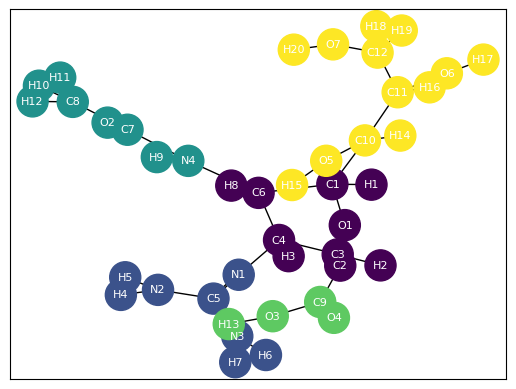


Graph created for Oseltamivir.pdb:
Center of the graph: ['C5']
Radius of the graph: 6
Diameter of the graph: 12
Degree sequence of the graph: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of nodes: 50
Number of edges: 53
Communities: ({1, 2, 3, 4, 5, 23, 24, 25, 26, 27}, {6, 7, 8, 41, 46, 15, 47, 49, 50, 48, 20, 21, 22, 28, 29}, {36, 37, 38, 39, 40, 9, 10, 13, 14, 30}, {32, 33, 34, 35, 11, 12, 31}, {42, 43, 44, 45, 16, 17, 18, 19})


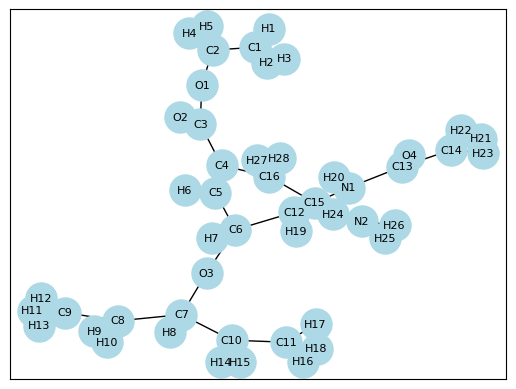

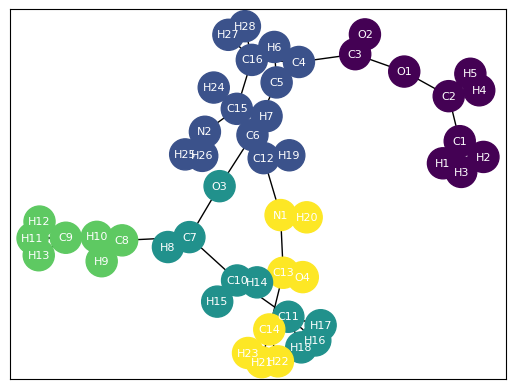

In [12]:
file_names = ['Peramivir.pdb', 'Zanamivir.pdb', 'Oseltamivir.pdb']
for file_name in file_names:
    print()
    G = createG(file_name)
    print(f"Graph created for {file_name}:")
    #G_attr(G)
    G_det(G)
    communities = detect_communities_girvan_newman(G)
    print("Communities:", communities)
    draw2d(G)
    draw2d_comm(G)

Graph created for Peramivir.pdb:
Vertices and their attributes:
Node 1: {'serial': 1, 'name': 'C1', 'residue_name': 'UNL', 'element': 'C', 'x': 0.689, 'y': 0.263, 'z': 0.044, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 2: {'serial': 2, 'name': 'C2', 'residue_name': 'UNL', 'element': 'C', 'x': -0.747, 'y': 0.111, 'z': 0.252, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 3: {'serial': 3, 'name': 'N1', 'residue_name': 'UNL', 'element': 'N', 'x': -0.985, 'y': 0.229, 'z': 1.753, 'weight': 14.01, 'size': 1.55, 'charge': 1}
Node 4: {'serial': 4, 'name': 'C3', 'residue_name': 'UNL', 'element': 'C', 'x': -1.402, 'y': -0.885, 'z': 2.509, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 5: {'serial': 5, 'name': 'C4', 'residue_name': 'UNL', 'element': 'C', 'x': -1.633, 'y': -0.765, 'z': 3.969, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 6: {'serial': 6, 'name': 'O1', 'residue_name': 'UNL', 'element': 'O', 'x': -1.587, 'y': -2.0, 'z': 1.96, 'weight': 16.0, 'size': 1.52, 'charge': -2}
Node 

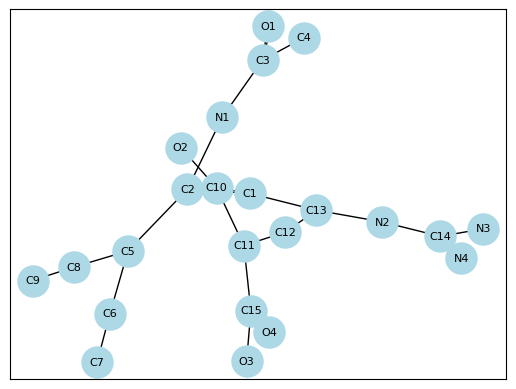

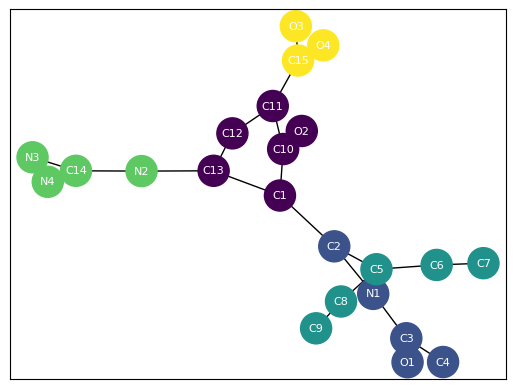

In [13]:
file_name = 'Peramivir.pdb'
G1 = createG(file_name)
print(f"Graph created for {file_name}:")
remove_hydrogen_nodes(G1)
G_attr(G1)
G_det(G1)
communities = detect_communities_girvan_newman(G1)
print("Communities:", communities)
draw2d(G1)
draw2d_comm(G1)


Graph created for Zanamivir.pdb:
Vertices and their attributes:
Node 1: {'serial': 1, 'name': 'C1', 'residue_name': 'UNL', 'element': 'C', 'x': -0.807, 'y': -0.115, 'z': -0.155, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 2: {'serial': 2, 'name': 'O1', 'residue_name': 'UNL', 'element': 'O', 'x': -0.647, 'y': -1.511, 'z': 0.045, 'weight': 16.0, 'size': 1.52, 'charge': -2}
Node 3: {'serial': 3, 'name': 'C2', 'residue_name': 'UNL', 'element': 'C', 'x': 0.461, 'y': -2.142, 'z': -0.504, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 4: {'serial': 4, 'name': 'C3', 'residue_name': 'UNL', 'element': 'C', 'x': 1.583, 'y': -1.486, 'z': -0.509, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 5: {'serial': 5, 'name': 'C4', 'residue_name': 'UNL', 'element': 'C', 'x': 1.707, 'y': -0.129, 'z': 0.04, 'weight': 12.01, 'size': 1.7, 'charge': 0}
Node 6: {'serial': 6, 'name': 'N1', 'residue_name': 'UNL', 'element': 'N', 'x': 2.395, 'y': -0.313, 'z': 1.339, 'weight': 14.01, 'size': 1.55, 'charge': 1}

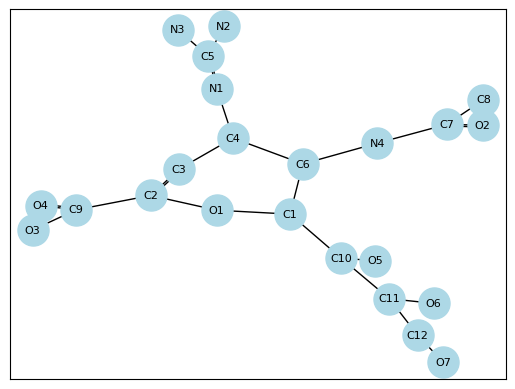

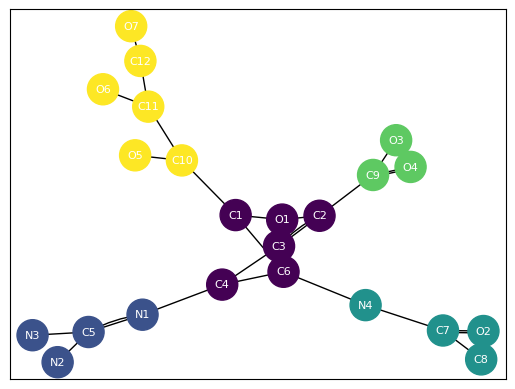

In [14]:
file_name = 'Zanamivir.pdb'
G2 = createG(file_name)
print()
print(f"Graph created for {file_name}:")
remove_hydrogen_nodes(G2)
G_attr(G2)
G_det(G2)
communities = detect_communities_girvan_newman(G2)
print("Communities:", communities)
draw2d(G2)
draw2d_comm(G2)

Graph created for Oseltamivir.pdb:
Center of the graph: ['C5']
Radius of the graph: 5
Diameter of the graph: 10
Degree sequence of the graph: [4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Number of nodes: 22
Number of edges: 25
Communities: ({1, 2, 3, 4, 5}, {6, 7, 8, 15, 20, 21, 22}, {9, 10, 13, 14}, {11, 12}, {16, 17, 18, 19})


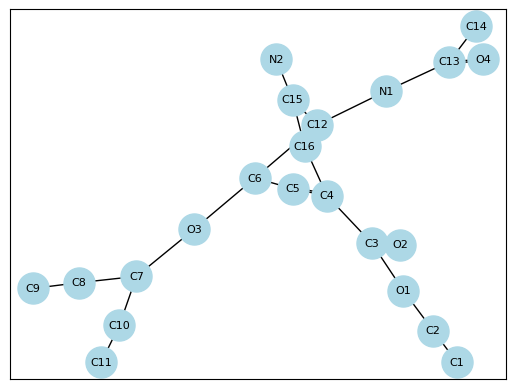

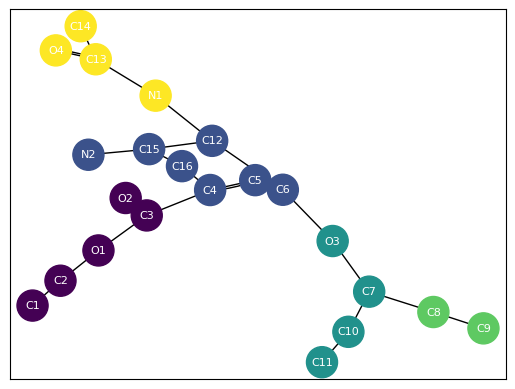

In [22]:
file_name = 'Oseltamivir.pdb'
G3 = createG(file_name)
print(f"Graph created for {file_name}:")
remove_hydrogen_nodes(G3)
#G_attr(G3)
G_det(G3)
communities = detect_communities_girvan_newman(G3)
print("Communities:", communities)
draw2d(G3)
draw2d_comm(G3)

In [16]:
print("Is G1 and G2 isomorphic?", nx.is_isomorphic(G1, G2))
print()
print("Is G1 and G3 isomorphic?", nx.is_isomorphic(G1, G3))
print()
print("Is G2 and G3 siomorphic?", nx.is_isomorphic(G3, G2))

Is G1 and G2 isomorphic? False

Is G1 and G3 isomorphic? False

Is G2 and G3 siomorphic? False


In [17]:
def jaccard_similarity(g1, g2):
    edges_g1 = set(g1.edges())
    edges_g2 = set(g2.edges())
    intersection = len(edges_g1.intersection(edges_g2))
    union = len(edges_g1.union(edges_g2))
    return intersection / union

In [18]:
print(f"Jaccard Similarity between")
print(f"G1 and G2: {jaccard_similarity(G1, G2)}")
print(f"G2 and G3: {jaccard_similarity(G2, G3)}")
print(f"G1 and G3: {jaccard_similarity(G1, G3)}")

Jaccard Similarity between
G1 and G2: 0.3142857142857143
G2 and G3: 0.3235294117647059
G1 and G3: 0.3235294117647059


In [19]:
def extract_element_edges(G):
    element_edges = []
    for u, v, data in G.edges(data=True):
        element_u = G.nodes[u]['element']
        element_v = G.nodes[v]['element']
        edge = (element_u, element_v) if element_u <= element_v else (element_v, element_u)
        element_edges.append(edge)
    return element_edges

def common_edge_ratio(G1, G2):
    edges_G1 = extract_element_edges(G1)
    edges_G2 = extract_element_edges(G2)
    print(edges_G1)
    print()
    print(edges_G2)
    print()
    print()
    
    count_G1 = Counter(edges_G1)
    count_G2 = Counter(edges_G2)
    
    common_edges_count = sum((count_G1 & count_G2).values())
    
    all_edges_count = len(edges_G1) + len(edges_G2) - common_edges_count
    
    return common_edges_count / all_edges_count

In [20]:
ratio_G1_G2 = common_edge_ratio(G1, G2)
ratio_G1_G3 = common_edge_ratio(G1, G3)
ratio_G2_G3 = common_edge_ratio(G2, G3)

[('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'N'), ('C', 'C'), ('C', 'N'), ('C', 'C'), ('C', 'O'), ('C', 'O'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'O'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'O'), ('C', 'O'), ('C', 'O')]

[('C', 'O'), ('C', 'C'), ('C', 'C'), ('C', 'O'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'N'), ('C', 'C'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'C'), ('C', 'O'), ('C', 'O'), ('C', 'O'), ('C', 'O'), ('C', 'O'), ('C', 'O'), ('C', 'C'), ('C', 'O'), ('C', 'C'), ('C', 'O')]


[('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'N'), ('C', 'C'), ('C', 'N'), ('C', 'C'), ('C', 'O'), ('C', 'O'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'O'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'C'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'N'), ('C', 'O'), ('C', 'O'), ('C', 'O')]

[('C', 'C'), ('C', 'O'), ('C', 'O'), ('C', 'O

In [21]:
print(f"Ratio of common edges to all edges between G1 and G2: {ratio_G1_G2:.2f}")
print()
print(f"Ratio of common edges to all edges between G1 and G3: {ratio_G1_G3:.2f}")
print()
print(f"Ratio of common edges to all edges between G2 and G3: {ratio_G2_G3:.2f}")

Ratio of common edges to all edges between G1 and G2: 0.77

Ratio of common edges to all edges between G1 and G3: 0.76

Ratio of common edges to all edges between G2 and G3: 0.68
